<center><h1>Implementation of SaShiMi</h1><h3>From paper <a href="https://arxiv.org/abs/2202.09729">It's Raw! Audio Generation with State-Space Models</a></h3></center>

**Paper authors:** Karan Goel, Albert Gu, Chris Donahue, Christopher Ré

**Code authors:** İlker Işık (e238051@metu.edu.tr), Muhammed Can Keleş (e265013@metu.edu.tr)

# SaShiMi Architecture

SaShiMi is a deep-learning model designed for generating raw audio. It is built around the recently introduced S4 model (from paper <a href="https://arxiv.org/abs/2111.00396">"Efficiently Modeling Long Sequences with Structured State Spaces"</a>), which is designed for sequence-to-sequence processing tasks. In SaShiMi, the authors modify S4 for better stability and achieve state-of-the-art results on multiple audio domains (music and speech), with less parameters and shorter inference time.


Here, we borrow Figure 1 from the paper:

<img src="images/sashimi-architecture.png" alt="SaShiMi Figure"/>

## S4 Block

The main component of SaShiMi architecture is the **S4 Block**. The paper explains the details of S4 block in Appendix A.2.

### High-level Architecture

First pass:
1. Input
2. LayerNorm
3. S4 Layer
4. GELU
5. Linear
6. Residual connection from 1

Second pass:
1. Output of the first pass
2. LayerNorm
3. Linear
4. GELU
5. Linear
6. Residual connection from 1

All linear layers are position-wise, i.e., they operate on the signal dimensions, not
the time dimension.

## S4 Layer

At a high-level, S4 layer can be thought of as a mapping from a 1D sequence to another 1D sequence. Some of the important properties of S4:
- It's causal. The output at index $i$ depends on inputs from $0$ to $i-1$.
- It can be computed using either convolution or recurrence.
    - We use convolution during training and recurrence during sampling.
- Although it's 1D to 1D, we stack multiple S4 Layers together to process multidimensional signals.
    - In this case, different dimensions don't interact with each other.
    - Linear layers compute interactions between different signal dimensions but they cannot handle interactions through time. Therefore, linear layers complement S4 layers nicely.
- S4 doesn't provide non-linearity by itself. It needs to be combined with activation functions.

For more information, you can read the [paper](https://arxiv.org/abs/2202.09729) or the source code of our S4 implementation. Our code contains many docstrings and comments.

## State Space Models

S4 stands for **structured state-space model**. But what is a state space model?

A state space model (SSM) is a new class of deep neural network that exhibits the properties of both CNNs and RNNs. 
In continuous time, SSM can be defined as follows:

$$h'(t) = Ah(t) + Bx(t)$$
$$y(t) = Ch(t) + Dx(t)$$

We can discretize the matrices $A$, $B$, $C$ and $D$ as follows:

$$\overline{A} = (I - \Delta/2 \cdot A)^{-1}(I + \Delta/2 \cdot A)$$

Discretization formulas for $B$, $C$ and $D$ are similar. Once we obtain $\overline{A}$, $\overline{B}$, $\overline{C}$ and $\overline{D}$, the discretized system is:

$$h_{k} = \overline{A} h_{k-1} + \overline{B} x_k$$
$$y_k = \overline{C} h_k + \overline{D} x_k$$

This discretized system is evaluated in a recurrent manner. But we can compute the convolutional kernel $\overline{K}$:

$$\overline{K} =
  (\overline{C}\overline{B}, \overline{C}\overline{A}\overline{B}, \overline{C}\overline{A}^2\overline{B}, \ldots)$$

And using $\overline{K}$, computing $y$ from $x$ can be performed in a single convolution operation:

$$y = \overline{K} \ast x$$

## S4 Details

Despite their theoretically attractive properties, SSMs deliver disappointing performance in practice. S4 was originally developed to overcome these deficiencies.

S4 is a subset of SSM where the matrix $A$ is in _diagonal plus low-rank_ (DPLR) form, i.e., for a diagonal matrix $\Lambda$,

$$A = \Lambda + p q^*$$

Furthermore, in S4, the matrices $A$ (more specifically, $\Lambda$, $p$ and $q$) and $B$ are initialized according to **HiPPO**. HiPPO stands for **High-order Polynomial Projection Operator**. The state space model defined by HiPPO creates a lossy summary of the signal processed so far.

For more information on HiPPO, see the paper [HiPPO: Recurrent Memory with Optimal Polynomial Projections](https://arxiv.org/abs/2008.07669).

## Contributions to S4

In SaShiMi paper, the authors make several improvements to S4.

When sampling, the recurrent representation of S4 is unstable. The authors observe the source of unstability using state space theory and provide a simple S4 reparameterization that ensures stability theorically. In particular, they change the formulation of $A$ from $A = \Lambda + p q^*$ to

$$A = \Lambda - p p^*$$

There's also a **bidirectional S4** variant presented in the paper, which is simply the concatenation of two S4 layers but one of them is run in reverse order. However, it obviously breaks causality and hence it's not used for autoregressive tasks. Thus, we won't implement it in this notebook.

## Up-Pool and Down-Pool

The next components **up-pool** and **down-pool** are combinations of reshaping and a linear layer.

In particular, for an input of shape $(T, H)$ where $T$ is the sequence length (sample count) and $H$ is the signal dimension, the **down-pool** is

$$
(T,H) \xrightarrow{\text{reshape}} (T/p, H \cdot p) \xrightarrow{\text{linear}} (T/p, H \cdot q)
$$

where $p$ is the pooling factor and $q$ is the expansion factor.

**Up-pool** is simply the opposite operation:

$$
(T/p, H \cdot q) \xrightarrow{\text{linear}} (T/p, H \cdot p) \xrightarrow{\text{reshape}} (T,H)
$$

They use $p=4$ and $q=2$ in the paper.

Note that we use our own `Sequential` implementation instead of `torch.nn.Sequential`. Our implementation inherits `torch.nn.Sequential` and accounts for the S4 layer when we want to run it in recurrent mode. `Residual` is the same as `Sequential` but it applies a residual connection from the beginning to the end, i.e., $Residual(x) = x + Sequential(x)$.

# Prelude

Before starting, follow the instructions in README and make sure that:
1. The required libraries given in README are installed.
2. You have downloaded the datasets and pretrained models.

In the following code blocks, we will setup, import modules, select device, etc.

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile
import os

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

The dataset is actually just the audio track of [this 4 hour piano video from YouTube](https://www.youtube.com/watch?v=EhO_MrRfftU). It's resampled at 16 kHz and divided into 1 minute WAV files. Thankfully, the authors of the paper have already done this step and uploaded the processed dataset [here on HuggingFace](https://huggingface.co/datasets/krandiash/youtubemix).

In [17]:
DURATION = 8
train_dataset = YoutubeMixDataset("./datasets/youtube-mix/train", duration=DURATION, device=device)

In [18]:
len(train_dataset)

1589

In [19]:
# Check sample rate
assert train_dataset.sample_rate == 16000

x, y = train_dataset[0]
assert list(x.size()) == [DURATION * 16000]
assert list(y.size()) == [DURATION * 16000]

`y` contains all samples 0 to N in the sound file, each sample is an integer between 0 and 255. `x`, on the other hand, contains samples 0 to N-1, each sample is an integer between 0 to 255. For each input sample $i$, the network predicts the probabilities for the next sample ($i+1$) in 8-bits using the inputs from $0$ to $i$.

Let's listen to one of the sound files in the dataset:

In [ ]:
ipd.Audio(mu_law_decoding(x, 256).cpu().numpy(), rate=16000)

# The Model

Here, we define the SaShiMi model with the hyperparameters given in Appendix C.2.1. We use a block count of 2 instead of 8 in the overfitting test for faster training.

In [30]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*DURATION,
    block_count=2,
    encoder=Embedding(256, 64),
).to(device)

For simplicity, they don't train the low-rank term $pp^*$, the $B$ matrix and the timescale $\Delta$. In TODO experiments, we do the same, but we still train $\Delta$ because they don't provide the initial value for that parameter.

However, we found that freezing these parameters is highly detrimental in overfitting test. Therefore, we won't do that here.

In [31]:
for module in model.modules():
    # isinstance doesn't work due to automatic reloading
    if type(module).__name__ == S4Base.__name__:
        module.B.requires_grad = False
        module.P.requires_grad = False

Let's inspect the number of parameters in our model:

In [32]:
print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 1347078
Parameters to be learned: 1345542


# Training the Model: Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

In [33]:
x, y = train_dataset[0]
overfit_dataset = [(x, y)]

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/1000 [00:00<?, ?it/s]

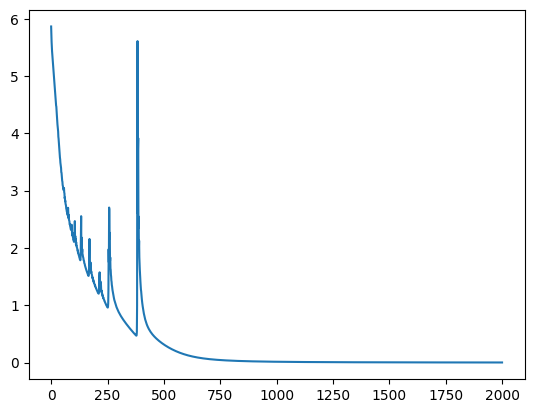

0.001631121034733951

In [38]:
model.train()
for epoch in tqdm(range(2000), leave=False):
    for x, y in overfit_dataset:
        y_hat = model(x)
        loss = criterion(y_hat.view(-1, 256), y.view(-1))

        loss_val = loss.detach().cpu().item()
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()
losses[-1]

Note that even though the loss seems flat in the last half of the training, it makes a huge difference while sampling.

## Sampling

The following method will autoregressively sample from the given model `m`. It can optionally use a priming signal to start with. When `maxp` is `True`, it will always choose the value with highest probability instead of random sampling.

Let's generate a sample and listen to it:

  0%|          | 0/128000 [00:00<?, ?it/s]

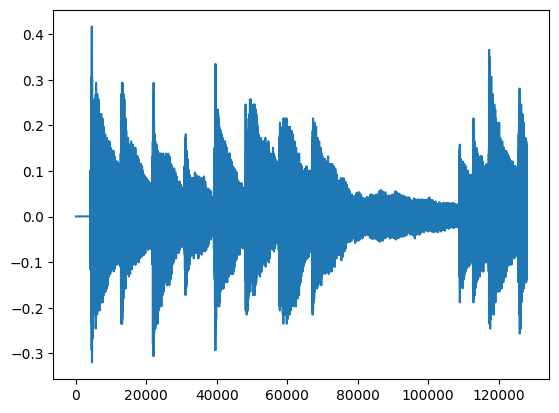

In [43]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 8*16000, maxp=True).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

We can also save it as WAV:

In [44]:
wavfile.write("overfitting.wav", 16000, gen.flatten().numpy())

We can save this model together with the optimizer state as follows:

In [41]:
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}, "./models/ym-overfitting.pt")

Then, we can load the model and the optimizer from their `state_dict`s similarly:

In [42]:
checkpoint = torch.load("./models/ym-overfitting.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

# Full Dataset Training

Since training on the full dataset takes a lot of time, we won't demonstrate it in this notebook. The training script `train.py` is available in the repository, see `README.md` for details.

## Loading a Pre-Trained Model

The following function will load a pre-trained model. You should have downloaded the pre-trained models using `download_data.sh` script. All pre-trained models should be available in `models` folder.

In [7]:
def load_model(model, name, _epoch=None):
    global epoch, device, model_name, model_folder
    model_name = name
    model_folder = "./models/" + name

    with open(os.path.join(model_folder, "train_loss.txt"), 'r') as f:
        train = [float(i.strip()) for i in f.readlines()]

    with open(os.path.join(model_folder, "validation_loss.txt"), 'r') as f:
        valid = [float(i.strip()) for i in f.readlines()]

    plt.title(label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train)
    plt.plot(valid)

    epoch = len(train) if _epoch is None else _epoch
    checkpoint_filename = os.path.join(model_folder, f"epoch{epoch:04d}.pt")
    print("Loading model:", checkpoint_filename)
    checkpoint = torch.load(checkpoint_filename, map_location=device)

    return model.load_state_dict(checkpoint["model_state"])

In [8]:
model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=8,
    encoder=Embedding(256, 64),
).to(device)

print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 4302744
Parameters to be learned: 4302744


The following code block will load the pre-trained model and plot the losses.

Here's how we scheduled the learning rate manually throughout the training process:
- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 60, the learning rate was reduced to 0.00025.
- Starting at epoch 99, the learning rate was reduced to 0.000125.
- Starting at epoch 140, the learning rate was reduced to 0.00004.

Loading model: ../models/ym-8l/epoch0160.pt


<All keys matched successfully>

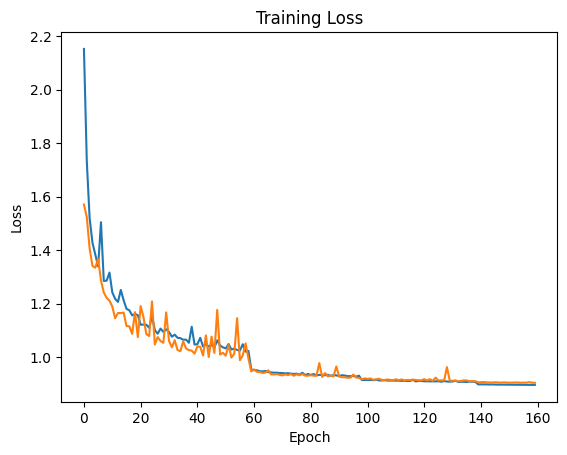

In [9]:
load_model(model, "ym-8l")

Now, let's sample from this model that has been trained on the full YouTube Mix dataset.

The following code block will generate 32 samples at once and save them.

In [11]:
seed = 42
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 8*16000, batch_size=32)
    gen = mu_law_decoding(gen, 256).cpu()

dirname = "outputs/" + model_name
if not os.path.exists(dirname):
    os.makedirs(dirname)

for i, g in enumerate(gen):
    wavfile.write(f"{dirname}/epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/128000 [00:00<?, ?it/s]

Let's listen to the generated samples.

In [12]:
selected_index = 0

In [ ]:
selected = gen[selected_index]
print("Sample", selected_index)
selected_index = (selected_index + 1) % gen.size(dim=0)
plt.figure()
plt.plot(selected)
ipd.Audio(selected.numpy(), rate=16000)

You can run the previous block repeatedly to switch to the next sample.

Since the audio files cannot be saved inside a Jupyter Notebook unlike images, we provide the samples separately. **You can listen to our samples [in this link](https://necrashter.github.io/sashimi-796).**

# Reproducing the Results

By sampling from the model in the previous section, we have seen some qualitative results. You can compare our samples with the official samples provided on [this webpage](https://hazyresearch.stanford.edu/sashimi-examples/).

To get quantitative results, we need to compute negative log likelihood (NLL) values on the test dataset.

## NLL Test

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [14]:
test_dataset = YoutubeMixDataset("./datasets/youtube-mix/test", duration=8, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_nll(model):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        nll = 0.0
        for x, y in tqdm(test_dataloader, leave=False):
            y_hat = model(x)
            nll += criterion(y_hat.view(-1, 256), y.view(-1))
        nll /= len(test_dataloader)

        print("Average NLL:", nll.item())
        print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
        print("Average NLL converted to probability:", (-nll).exp().item())

len(test_dataset)

111

In [15]:
test_nll(model)

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 0.9182284474372864
Average NLL in base 2: 1.3247236013412476
Average NLL converted to probability: 0.3992256820201874


For comparison, the test NLL provided in the paper is **1.294** in base 2. Our results are close, albeit slightly worse. However, please note that they train this model longer in the paper (**600K steps** on page 19, which would be about 400 epochs in our setup). We could only train it for 160 epochs. We believe it's reasonable to expect that our model can achieve the same or better NLL value with longer training and better hyperparameter choices. For example, they might have used a different optimizer and a better learning rate schedule.

# Generating Longer Samples

Although the model was trained on 8-second chunks, it can generate samples of unbounded length thanks to being an auto-regressive model. In this section, we will generate 64-second long samples and save them. Again, we are unable to save them inside the notebook but we provided them separately. 

In [16]:
seed = 0
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 64*16000, batch_size=16)
    gen = mu_law_decoding(gen, 256).cpu()

dirname = "outputs/" + model_name
if not os.path.exists(dirname):
    os.makedirs(dirname)

for i, g in enumerate(gen):
    wavfile.write(f"{dirname}/long-epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/1024000 [00:00<?, ?it/s]

# Challenges

In this section, we list the challenges we faced while implementing the paper.

The challenges we overcame after version 1 submission:
1. The authors don't give detailed information about the encoder and decoder layers, i.e., what happens before/after the SaShiMi model. In version 1, we used linear layers to transform 1D input to 64 dimensions (encoder) and then 64 dimensional output to 256 dimensional probability output. When we switched from a linear layer to [embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) in the encoder, we observed significant improvements both in NLL and sample quality.
2. We didn't use [mu-law](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm) encoding in our version 1 submission. The authors clearly communicated this in Table 1, but we forgot to implement it due to our unfamiliarity with the audio domain.
3. Parameter tying was incorrect in our version 1 submission.
    - In particular, this was the version 1 submission:
        - $\Lambda$, $p$: Shared
        - $B$: Separate
        - $C$: Shared
    - This is the updated version:
        - $\Lambda$, $p$: Shared
        - $B$: Shared
        - $C$: Separate
    - The updated version reflects the details given in Appendix C.2.1. In our version, $dt$ is also shared but learned unlike what the paper describes. As mentioned previously, our model learns $dt$ because they didn't provide the initial value for $dt$. We tried learning a separate $dt$ for each dimension [in this PR](https://github.com/necrashter/SaShiMi-796/pull/17), but this results in a separate $A$ matrix for each dimension, which causes a significant slowdown. Also we didn't observe any noteworthy benefit from learning a separate $dt$ for each dimension.

General difficulties we dealt with:
1. The details of S4 are not given in the SaShiMi paper. We had to go back to the S4's paper and implement it from scratch, which took the first few weeks of our time. It was like implementing two papers at once.
2. While describing the model structure in Appendix C.2.1, the authors provide the "model dimension", but it's unclear whether this term refers to the hidden dimension of the signal or the state dimensions (size of $x$ computed by $A$ and $B$ matrices). See the Ablation notebook for more information about this.
3. The authors give the learning rate for SaShiMi model, but they don't tell the name of the optimizer. We used `AdamW` in all of our experiments on Youtube Mix.